# Andrew Ng's Machine Learning Ex. 3: Multi-class Classification and NNs

In [1]:
from __future__ import division

In [2]:
import numpy as np
from scipy.optimize import minimize
import scipy.io # used to load matlab-formatted .m files.
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import bqplot as bq # bqlot and IPython.display are used to create an interactive plot in the final section below
from IPython.display import display 
from sklearn.linear_model import LogisticRegression # used following the first section of the notebook

In [3]:
%matplotlib inline

In [4]:
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook")

In [5]:
def sns_reset(): 
    """Call this function to toggle back to the sns plotting environment from the matplotlib environment."""
    sns.reset_defaults()
    sns.set_style("white")
    sns.set_style("ticks")
    sns.set_context("notebook")

# Call these three functions at the top of the notebook to allow toggling between sns and matplotlib 
# environments while maintaining a uniform plot style throughout.
sns.reset_orig() 
sns_reset()
plt.ion()

Load the dataset used in both sections below.

In [6]:
data_dict = scipy.io.loadmat('../../data/handwritten_digits.mat')

In [7]:
X = data_dict['X']
y = data_dict['y'].ravel()

M = X.shape[0]
N = X.shape[1]

num_labels = len(np.unique(y)) # = 10

Add a column of ones to the data matrix that allows us to treat the intercept parameter as a feature.

In [8]:
X = np.hstack((np.ones((M, 1)), X))

Define the sigmoid function.

In [9]:
"""Python version of sigmoid.m."""
sigmoid = lambda x: 1 / (1 + np.exp(-x))

# 1 Multi-class classification

## 1.2 Visualizing the data

Draw ```dim * dim``` random examples of images from the dataset and display them in a grid.  Note:  Drop column of ones from X here.

In [10]:
dim = 10

examples = X[:, 1:][np.random.randint(M, size=dim * dim)]

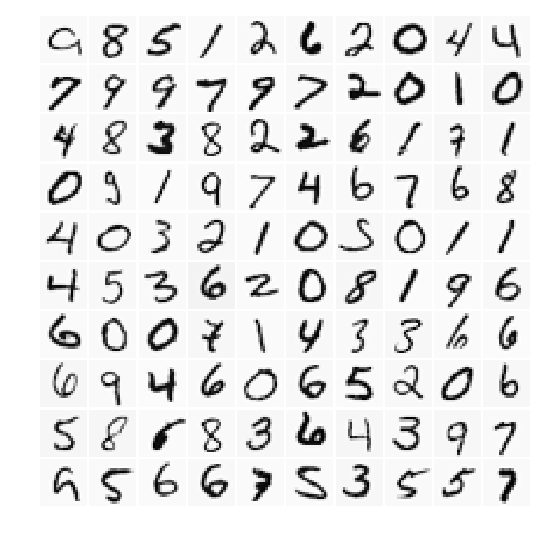

In [11]:
"""Python version of displayData.m."""
fig = plt.figure(figsize=(5, 5))

gs = gridspec.GridSpec(dim, dim)
gs.update(bottom=0.01, top=0.99, left=0.01, right=0.99, 
          hspace=0.05, wspace=0.05)

k = 0
for i in range(dim):
    for j in range(dim):
        ax = plt.subplot(gs[i, j])
        ax.axis('off')
        ax.imshow(examples[k].reshape(int(np.sqrt(N)), int(np.sqrt(N))).T,
            cmap=plt.get_cmap('Greys'), interpolation='nearest')
        k += 1

## 1.4 One-vs-all classification

Set the regularization parameter.

In [12]:
lam = 1.

Inialize all model parameters to zero. 

In [13]:
theta_0 = np.zeros(N + 1)

Define the cost function for regularized logistic regression.  (The exact same cost function is used in Exercise 2.3.)

In [14]:
cost_history = [] # Use this array to log costs calculated in the call to scipy's "minimize" below.

def cost_function(theta, X, y, M, lam):
    """Python version of lrCostFunction.m."""
    global cost_history
    
    cost = 1 / M * (- y.dot(np.log(sigmoid(theta.dot(X.T)))) - (1 - y).dot(np.log(1 - sigmoid(theta.dot(X.T))))) \
        + lam / 2 / M * np.sum(theta[1:]**2)
    grad = 1 / M * (sigmoid(theta.dot(X.T)) - y).dot(X) + lam / M * np.hstack(([0], theta[1:]))
    
    cost_history.append(cost)
    return cost, grad

Test it.

In [15]:
cost_0, _ = cost_function(theta_0, X, y, M, lam)

print('Cost at initial theta (zeros): %.3f' % cost_0)

Cost at initial theta (zeros): 160.394


### Train the "1's" classifer.

Use a one-hot encoding of the target variable.

In [16]:
y_1_hot = (y == 1).astype('float')

Run the optimization.

In [17]:
cost_history = []

"""This call to scipy's "minimize" is a Python version of the Octave call to "fminunc".""" 
res = minimize(cost_function, theta_0, method='L-BFGS-B', args=(X, y_1_hot, M, lam), jac=True) 

Check the result.

In [18]:
theta = res['x']

print('Cost at best-fit theta: %.3f' % res['fun'] )

Cost at best-fit theta: 0.027


(0, 0.7278045395879434)

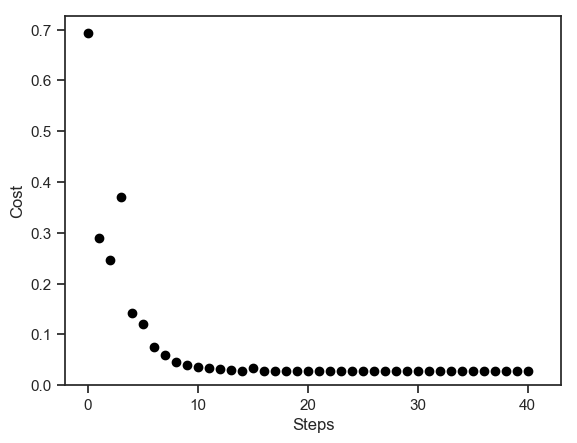

In [19]:
num_steps = len(cost_history) 

plt.figure()
plt.scatter(np.arange(num_steps), cost_history, c='k', marker='o')
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.xlim(-num_steps * 0.05, num_steps * 1.05)
plt.ylim(0, max(cost_history) * 1.05)

### Train all classifiers.

Run the same optimization as above for all 10 classes of digits.

In [20]:
def oneVsAll(theta_0, X, y, M, num_labels, lam):
    """Python version of oneVsAll.m."""
    all_theta = np.zeros((num_labels, N + 1))
    for i in range(1, num_labels + 1): # note that 0s are labeled with a y-value of 10 in this dataset.
        y_i_hot = (y == i).astype(np.float64)
        cost_history = [] # reset cost_history for each call to cost_function (even though cost_history not used here)
        res = minimize(cost_function, theta_0, method='L-BFGS-B', args=(X, y_i_hot, M, lam), jac=True) 
        all_theta[i - 1] = res['x']
    return all_theta

In [21]:
all_theta = oneVsAll(theta_0, X, y, M, num_labels, lam)

### 1.4.1 One-vs-all prediction

In [22]:
def prediction(all_theta, X):
    """Python version of predictOneVsAll.m."""
    return sigmoid(all_theta.dot(X.T)).T.argmax(axis=1) + 1

def accuracy(all_theta, X, y, M):
    return np.mean(prediction(all_theta, X) == y)

In [23]:
print('Train Accuracy: %.4f' % accuracy(all_theta, X, y, M))

Train Accuracy: 0.9446


# Multi-class classification with scikit-learn

The 'LogisticRegression' classifier is generated here with the regularization parameter, $C=1/\lambda$, set to '1'.  Setting 'penalty' to 'l2' specifies the use of L2 regularization.  Setting 'multi_class' to 'ovr' ('one-vs-rest') specifies the use of the cross-entropy cost function. These settings also happen to be the default parameters for the LogisticRegression classifier, so 'clf = LogisticRegression()' is equivalent to the first line below.  Note:  The data matrix, $X$, should have dimensions ```num_samples x num_features``` and should omit the initial column of ones.  The target vector, $y$, does not need to be one-hot encoded.

In [24]:
clf = LogisticRegression(C=1, penalty='l2', multi_class='ovr') 
clf.fit(X[:, 1:], y) 
print('Train Accuracy (sklearn): %.4f' % clf.score(X[:, 1:], y))

Train Accuracy (sklearn): 0.9438


The latter LogisticRegression classifier uses the 'liblinear' library to solve the optimization problem.  The following version uses the 'lbfgs' solver.  Notice that the resulting accuracy is identical to that in section 1.4.1 to 4 significant digits.

In [25]:
clf = LogisticRegression(C=1, penalty='l2', multi_class='ovr', solver='lbfgs') 
clf.fit(X[:, 1:], y) 
print ('Train Accuracy (sklearn): %.4f' % clf.score(X[:, 1:], y))

Train Accuracy (sklearn): 0.9446


# 2 Neural networks

Load the saved neural network parameters.

In [26]:
weights_dict = scipy.io.loadmat('../../data/handwritten_digits_neural_networks.mat')

In [27]:
theta_1 = weights_dict['Theta1']
theta_2 = weights_dict['Theta2']
print("Theta1 has shape:",theta_1.shape)
print("Theta2 has shape:",theta_2.shape)

Theta1 has shape: (25, 401)
Theta2 has shape: (10, 26)


## 2.2 Feedforward propagation and prediction

Calculate the activations of the hidden layer based on the data of the input layer.

In [28]:
a_2 = sigmoid(theta_1.dot(X.T))

In [29]:
a_2 = np.vstack((np.ones(M), a_2))

Calculate the activations of the output layer based on the activations of the hidden layer.

In [30]:
a_3 = sigmoid(theta_2.dot(a_2))

Make predictions and estimate accuracy.

In [31]:
def nn_prediction(a_3):
    """Python version of predict.m"""
    return a_3.argmax(axis=0) + 1

def nn_accuracy(a_3):
    return np.mean(nn_prediction(a_3) == y)

In [32]:
print('Training set accuracy: %.3f' % nn_accuracy(a_3))

Training set accuracy: 0.975


Use bqplot to display a sequence of randomly selected images from the dataset and the predicted classification.

In [33]:
nn_predictions = nn_prediction(a_3)

This following code block plots a single example from the dataset.

In [34]:
train_ex_num = np.random.randint(0, M)
train_ex = X[train_ex_num][1:]
train_ex = train_ex.reshape((20, 20)).T[::-1].flatten()
train_ex += abs(train_ex.min())
train_ex /= train_ex.max()

xs = bq.LinearScale()
ys = bq.LinearScale()
x_vals, y_vals = np.meshgrid(np.arange(20), np.arange(20))
scatt_1 = bq.Scatter(x=x_vals.ravel(), y=y_vals.ravel(), default_opacities=[1.0],
    scales={'x': xs, 'y': ys}, marker='square', default_colors=['white'], stroke_width=6.7)
scatt_2 = bq.Scatter(x=x_vals.ravel(), y=y_vals.ravel(), default_opacities=train_ex.tolist(),
    scales={'x': xs, 'y': ys}, marker='square', default_colors=['black'], stroke_width=6.7)
fig = bq.Figure(marks=[scatt_1, scatt_2], min_width=400, min_height=400, preserve_aspect=True, 
    title='Dataset label: %d; NN prediction: %d' % (y[train_ex_num] % 10, nn_predictions[train_ex_num] % 10))

display(fig)

Figure(fig_margin={'top': 60, 'bottom': 60, 'left': 60, 'right': 60}, layout=Layout(min_width='125px'), marks=…

The following code block can be executed multiple times to update the above plot with other examples. 

In [89]:
train_ex_num = np.random.randint(0, M)
train_ex = X[train_ex_num][1:]
train_ex = train_ex.reshape((20, 20)).T[::-1].flatten()
train_ex += abs(train_ex.min())
train_ex /= train_ex.max()

scatt_2.default_opacities = train_ex.tolist()
fig.title = 'Dataset label: %d; NN prediction: %d' \
    % (y[train_ex_num] % 10, nn_predictions[train_ex_num] % 10)

IndexError: index 4226 is out of bounds for axis 0 with size 200

In [86]:
display(fig)

Figure(fig_margin={'top': 60, 'bottom': 60, 'left': 60, 'right': 60}, layout=Layout(min_width='125px'), marks=…